In [1]:
# %matplotlib widget
%matplotlib ipympl
# from ipywidgets import *

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from scipy.ndimage import gaussian_filter

from __future__ import print_function
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from tqdm.notebook import trange, tqdm, tnrange
import time
from datetime import datetime

import math
import glob
import numpy as np


import itertools
import os.path
import os
import sys
from skimage.io import imread
import cv2

import pandas as pd

import imageio
from scipy.signal import savgol_filter
# import pytesseract 

from scipy.signal import find_peaks
matplotlib.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "arial"


import SimpleITK as sitk
import imageio

In [31]:
## Import functions
PathToFunctions = '/Users/iracicot/Documents/GitHub/HySE_HypercubeFunctions/'
sys.path.append(PathToFunctions)
from HySE_HypercubeFunctions import *

## Indicate which wavelengths were used (Panel4, Panel2), in nm

# Wavelengths_list = np.array([566,494,590,518,614,542,638, 578,506,602,530,626,554,650])
# SavingPath = '/Users/iracicot/Library/CloudStorage/OneDrive-UniversityofCambridge/Data/PoM/EndoscopeVideo/20240529/'
# ## Locate the data to analyse
# Name = 'Hand_Moving'
# # Name = 'Flat'
# # Name = 'Columns'
# DataPath = SavingPath
# vidPath = DataPath+Name+'.mpg'

Wavelengths_list = np.array([470,566,494,590,518,614,542,638, 482,578,506,602,530,626,554,650])
SavingPath = '//Users/iracicot/Library/CloudStorage/OneDrive-UniversityofCambridge/Data/PoM/EndoscopeVideo/20240524/'
## Locate the data to analyse
Name = 'Hand'

CropImDimensions = [166,680, 42,520] ## Dazzle, PoM

Add 'Help=True' in input for a list and description of all optional parameters 
Max plateau size set to 60
Min long dark size set to 180
Expected plateau size set to 35
ATTENTION: ReturnPeaks is set to True. Be careful, the output will have three elements!
Only importing the trace of the data
Cropping Image
Cropping image: x [166 : 680],y [42, 520]
No window length or polyorder input. Setting to 6, 1
Setting peak height to 1
Setting peak distance to 20

No sweep found. Set PlotGradient to True and play with parameters to improve detection
   To adjust smoothing: window_length, polyorder
   To adjust edge detection: peak_height, peak_distance
   To adjust the number of expected wavelengths: Ncolours


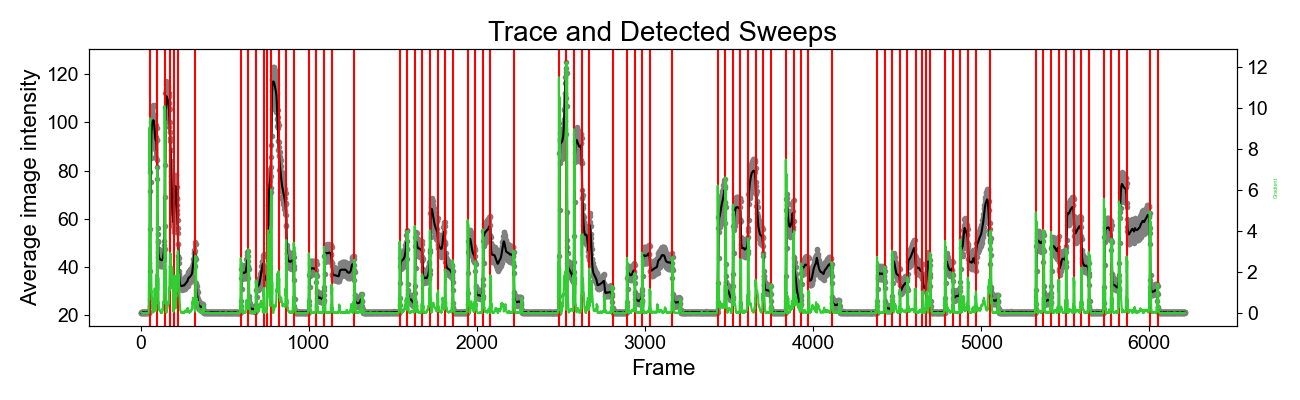

In [32]:
"""

I won't compute the full hypercube, but to help identify where to focus the co-registration,
it will be helpful to identify individual sweeps

Depending on the movement, I can then try to co-registrate individual sweeps
Or co-registrate all of them to be able to then average them together.


"""



## Find the positions of each wavelengths in the data trace
## Start with Help=True to have a list and descriptions of all the
## parameters to play with, and then with PlotGradient=True
## to help optimising

# Help()
## This dataset only has 14 wavelengths because one of the FSKs was off, will need a bit of adjusting

# EdgePos, Peaks, Peaks_dist = FindHypercube(vidPath, Wavelengths_list, PlotGradient=False, CropImDimensions=[166,680, 42,520], DarkMin=180, PlateauSize=35, 
#                                            MaxPlateauSize=60, PeakHeight=1, ReturnPeaks=True, Ncolours=7, PeakDistance=20)

EdgePos, Peaks, Peaks_dist = FindHypercube(vidPath, Wavelengths_list, PlotGradient=True, CropImDimensions=[166,680, 42,520], DarkMin=180, PlateauSize=35, 
                                           MaxPlateauSize=60, PeakHeight=1, ReturnPeaks=True, PeakDistance=20)


In [14]:
"""

To start, let's consider the first wavelength in the first sweep.
For this we'll need the EdgePos output from the FindHypercube function

Let"s consider the first sweep for simplicity

"""


print(EdgePos[0]) 

[[ 594   45]
 [ 639   45]
 [ 684   45]
 [ 729   49]
 [ 778   41]
 [ 819   45]
 [ 864   49]
 [ 913   35]
 [ 948   86]
 [ 999   45]
 [1044   45]
 [1089   49]
 [1138   41]
 [1179   45]
 [1224   45]
 [1269   49]]


In [11]:
"""

I will need to import the data. To avoid crashing my computer, I will just import from 0 to 460


"""

Data = ImportData(vidPath, 0, 460, CropImDimensions=CropImDimensions)
print(Data.shape)

Cropping Image
Cropping image: x [166 : 680],y [42, 520]
(1380, 478, 514)


In [15]:
Data_c1 = Data[EdgePos[0][0,0]:EdgePos[0][0,0]+EdgePos[0][0,1], :,:]
print(Data_c1.shape)

## This is what I need to co-register for now

(45, 478, 514)


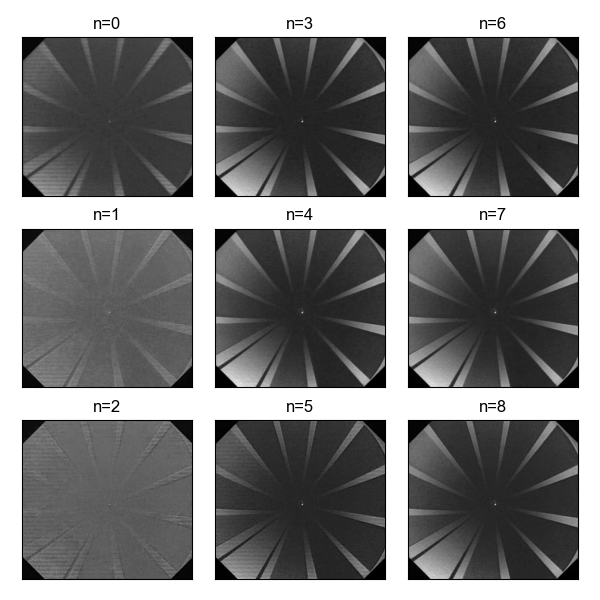

In [20]:
Nx, Ny = 3, 3

plt.close()
fig, ax = plt.subplots(nrows=Ny, ncols=Nx, figsize=(6,6))
n = 0
for i in range(0,Nx):
    for j in range(0,Ny):
        ax[j,i].imshow(Data_c1[n,:,:], cmap='gray')
        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([])
        ax[j,i].set_title(f'n={n}', fontsize=12)
        n += 1
plt.tight_layout()
plt.show()

In [ ]:
plt.close()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,8))
ax.plot(np.average(np.average(Data_c1, )))

In [ ]:
test0 = sitk.GetImageFromArray(image1)
test_Shift = sitk.GetImageFromArray(image2)


elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.LogToConsoleOff()

elastixImageFilter.SetFixedImage(test0)
elastixImageFilter.SetMovingImage(test_Shift)
# elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("rigid"))

# parameterMap = sitk.GetDefaultParameterMap('affine')
# parameterMap = sitk.GetDefaultParameterMap('rigid')

parameterMap = sitk.GetDefaultParameterMap('translation')
parameterMap['Transform'] = ['BSplineTransform']
# parameterMap['Transform'] = ['SplineKernelTransform']

parameterMap['MaximumNumberOfIterations'] = ['912']

elastixImageFilter.SetParameterMap(parameterMap)


test = elastixImageFilter.Execute()

test1 = sitk.GetArrayFromImage(test)